In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

**Load the prepared dataset from dataset preprocessing notebook which is saved in .npy format**

In [ ]:
data = np.load('/content/drive/My Drive/lfw-dataset.npy')
print(data.shape)

(1545, 2, 64, 64)


**Reshape**

In [ ]:
data = np.reshape(data, (1545, 2, 64, 64, 1))
print('No. of person: {}'.format(data.shape[0]))
print('No. of images per person: {}'.format(data.shape[1]))
print('Image dimension: {} * {}'.format(data.shape[2], data.shape[3]))

No. of person: 1545
No. of images per person: 2
Image dimension: 64 * 64


**Form triplets of anchor, positive and negative images**

In [ ]:
anchorImages = []
positiveImages = []
negativeImages = []
 
for i in range(data.shape[0]):
  neg_index = np.random.randint(0, data.shape[0], 37)

  while i in neg_index:
    neg_index = np.random.randint(0, data.shape[0], 37)
      
  for j in neg_index:
    a, b = np.random.permutation([0, 1])
    c = np.random.choice([0, 1])
    anchorImages.append(data[i,a,:,:,:])
    positiveImages.append(data[i,b,:,:,:])
    negativeImages.append(data[j,c,:,:,:])
 
print('No. of triplets: {}'.format(len(anchorImages)))

No. of triplets: 57165


**Shuffle the triplets and split it to train, validation and test sets**

In [ ]:
triplets = list(zip(anchorImages, positiveImages, negativeImages))
np.random.shuffle(triplets)

train_triplets = triplets[0:50000]
val_triplets = triplets[50000:54000]
test_triplets = triplets[54000:57000]
del triplets, anchorImages, positiveImages, negativeImages

anchorImagesTrain, positiveImagesTrain, negativeImagesTrain = zip(*train_triplets)
anchorImagesVal, positiveImagesVal, negativeImagesVal = zip(*val_triplets)
anchorImagesTest, positiveImagesTest, negativeImagesTest = zip(*test_triplets)
y = [np.ones((50000)), np.ones((50000)), np.ones((50000))]   # dummy target variable

anchorImagesTrain = np.array(anchorImagesTrain)
positiveImagesTrain = np.array(positiveImagesTrain)
negativeImagesTrain = np.array(negativeImagesTrain)
anchorImagesTest = np.array(anchorImagesTest)
positiveImagesTest = np.array(positiveImagesTest)
negativeImagesTest = np.array(negativeImagesTest)
anchorImagesVal = np.array(anchorImagesVal)
positiveImagesVal = np.array(positiveImagesVal)
negativeImagesVal = np.array(negativeImagesVal)

print('No. of training samples: {}'.format(anchorImagesTrain.shape[0]))
print('No. of validation samples: {}'.format(anchorImagesVal.shape[0]))
print('No. of test samples: {}'.format(anchorImagesTest.shape[0]))

No. of training samples: 50000
No. of validation samples: 4000
No. of test samples: 3000


**Display random 20 triplets**

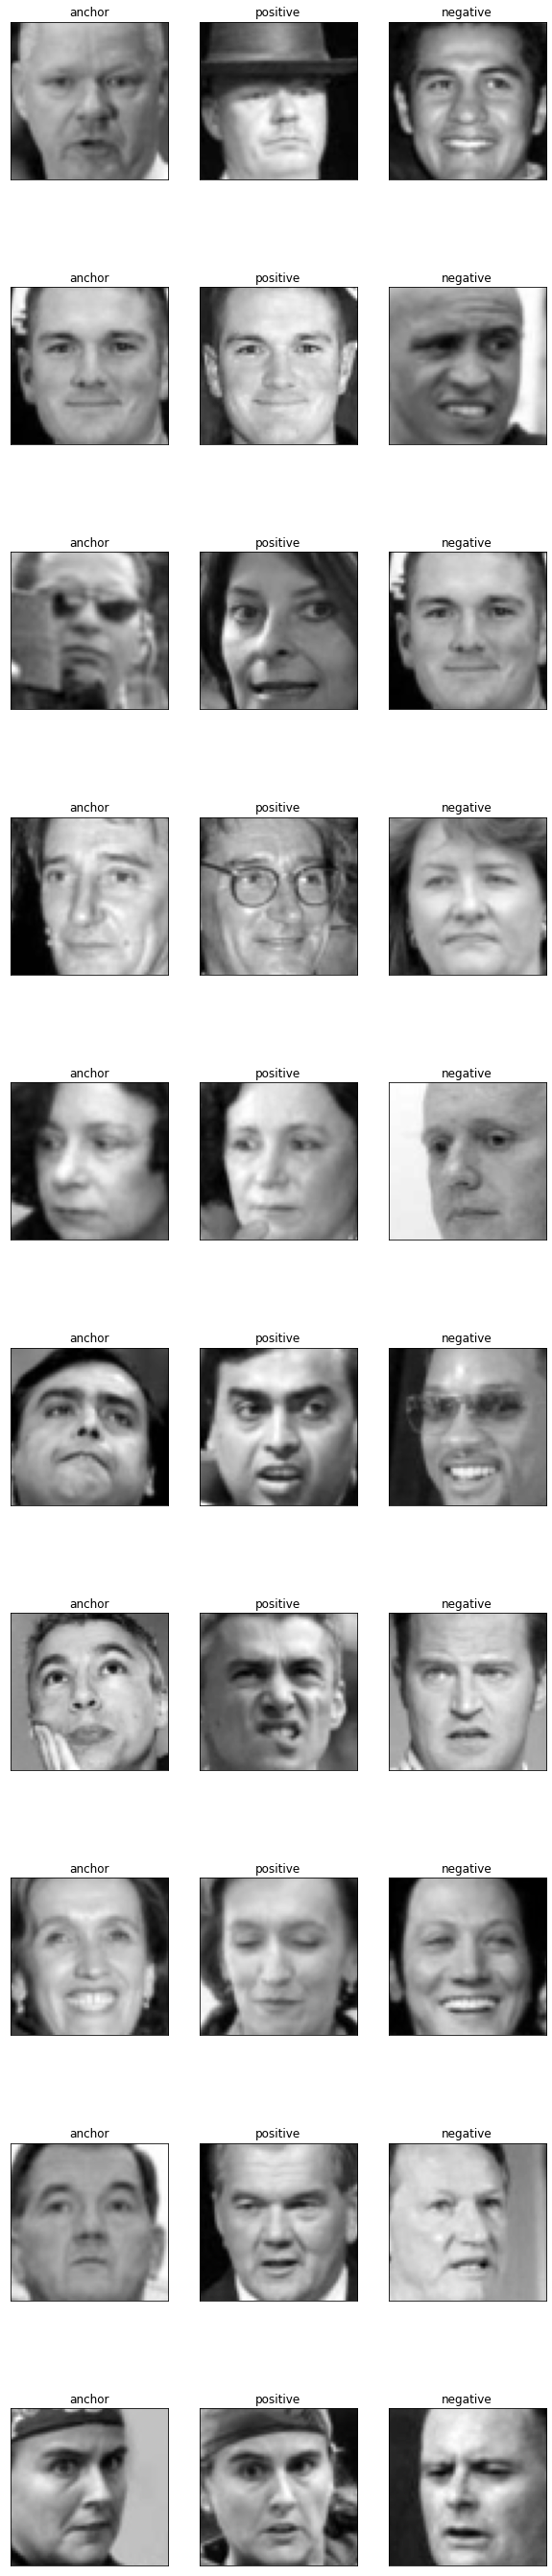

In [ ]:
fig, axarr = plt.subplots(nrows = 10, ncols = 3, figsize = (10, 50))
    
for i in range(10):
  axarr[i, 0].imshow(anchorImagesTrain[i,:,:,0], cmap='gray')
  axarr[i, 0].set_xticks([])
  axarr[i, 0].set_yticks([])
  axarr[i, 0].set_title("anchor")
  axarr[i, 1].imshow(positiveImagesTrain[i,:,:,0], cmap='gray')
  axarr[i, 1].set_xticks([])
  axarr[i, 1].set_yticks([])
  axarr[i, 1].set_title("positive")
  axarr[i, 2].imshow(negativeImagesTrain[i,:,:,0], cmap='gray')
  axarr[i, 2].set_xticks([])
  axarr[i, 2].set_yticks([])
  axarr[i, 2].set_title("negative")

In [ ]:
input_shape = anchorImagesTrain[0].shape[-3:]
input_shape

(64, 64, 1)

In [ ]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, Lambda, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

**Model to extract 64 features of an image**

In [ ]:
image_input = Input(shape = input_shape)
x = Conv2D(16,(3, 3), activation = 'relu')(image_input)
x = Conv2D(32,(3, 3), activation = 'relu', kernel_regularizer = l2())(x)
x = MaxPool2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64,(3, 3), activation = 'relu', kernel_regularizer = l2())(x)
x = Conv2D(32,(3, 3), activation = 'relu')(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(32,(3, 3), activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Conv2D(32,(3, 3), activation = 'relu', kernel_regularizer = l2())(x)
x = Conv2D(32,(3, 3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu', kernel_regularizer = l2())(x)
output = Dense(64, activation = 'sigmoid')(x)

featureExtractionModel = Model(inputs = image_input, outputs = output, name = 'feature_extraction_model')
featureExtractionModel.summary()

Model: "feature_extraction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28

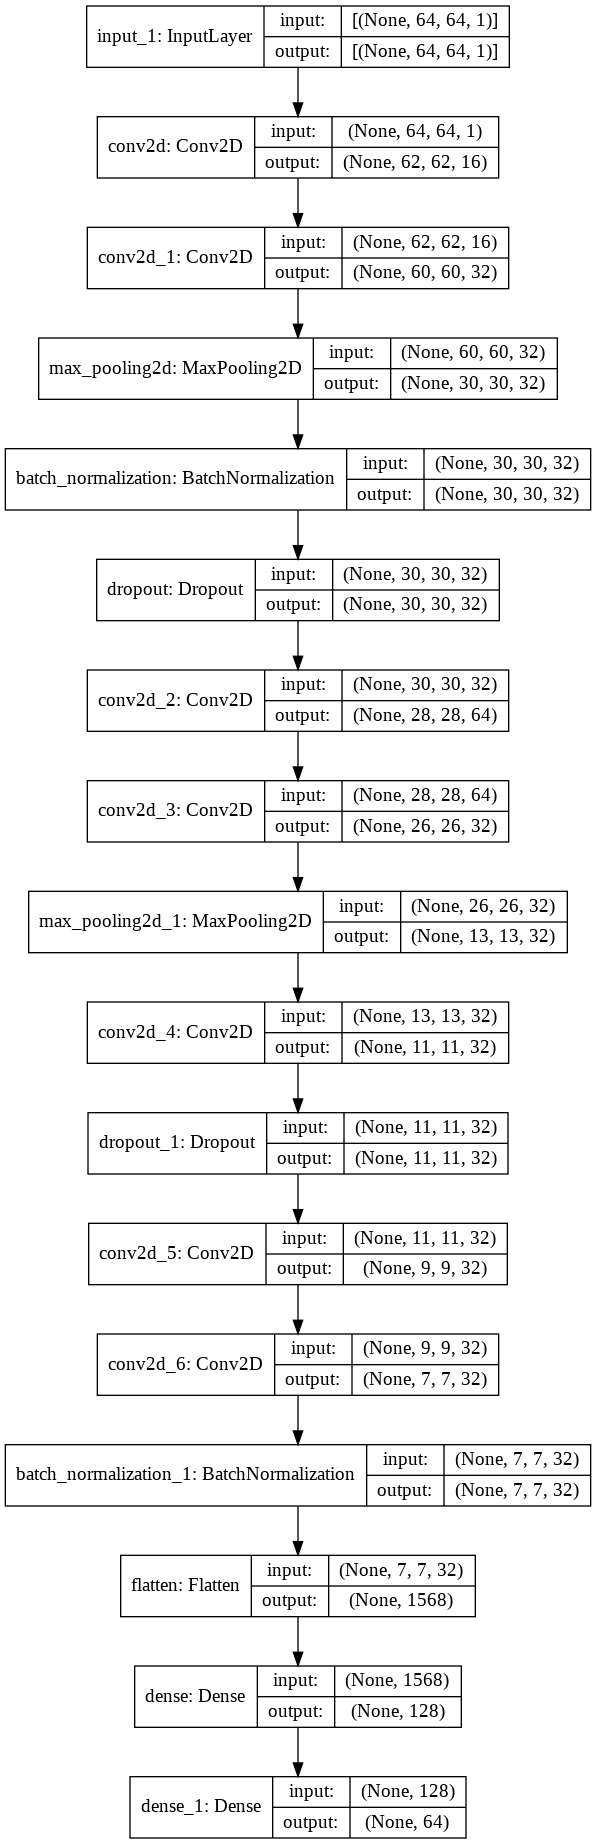

In [ ]:
keras.utils.plot_model(featureExtractionModel, "my_first_model_with_shape_info.png", show_shapes=True)

**Siamese network architecture**

In [ ]:
anchor = Input(shape = input_shape, name = 'anchorFeatures')
anchorFeatures = featureExtractionModel(anchor)

positive = Input(shape = input_shape, name = 'positiveFeatures')
positiveFeatures = featureExtractionModel(positive)

negative = Input(shape = input_shape, name = 'negativeFeatures')
negativeFeatures = featureExtractionModel(negative)

siameseModel = Model(inputs = [anchor, positive, negative], outputs = [anchorFeatures, positiveFeatures, negativeFeatures], name = 'siamese_model')
siameseModel.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchorFeatures (InputLayer)     [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
positiveFeatures (InputLayer)   [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
negativeFeatures (InputLayer)   [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
feature_extraction_model (Funct (None, 64)           278848      anchorFeatures[0][0]             
                                                                 positiveFeatures[0][0

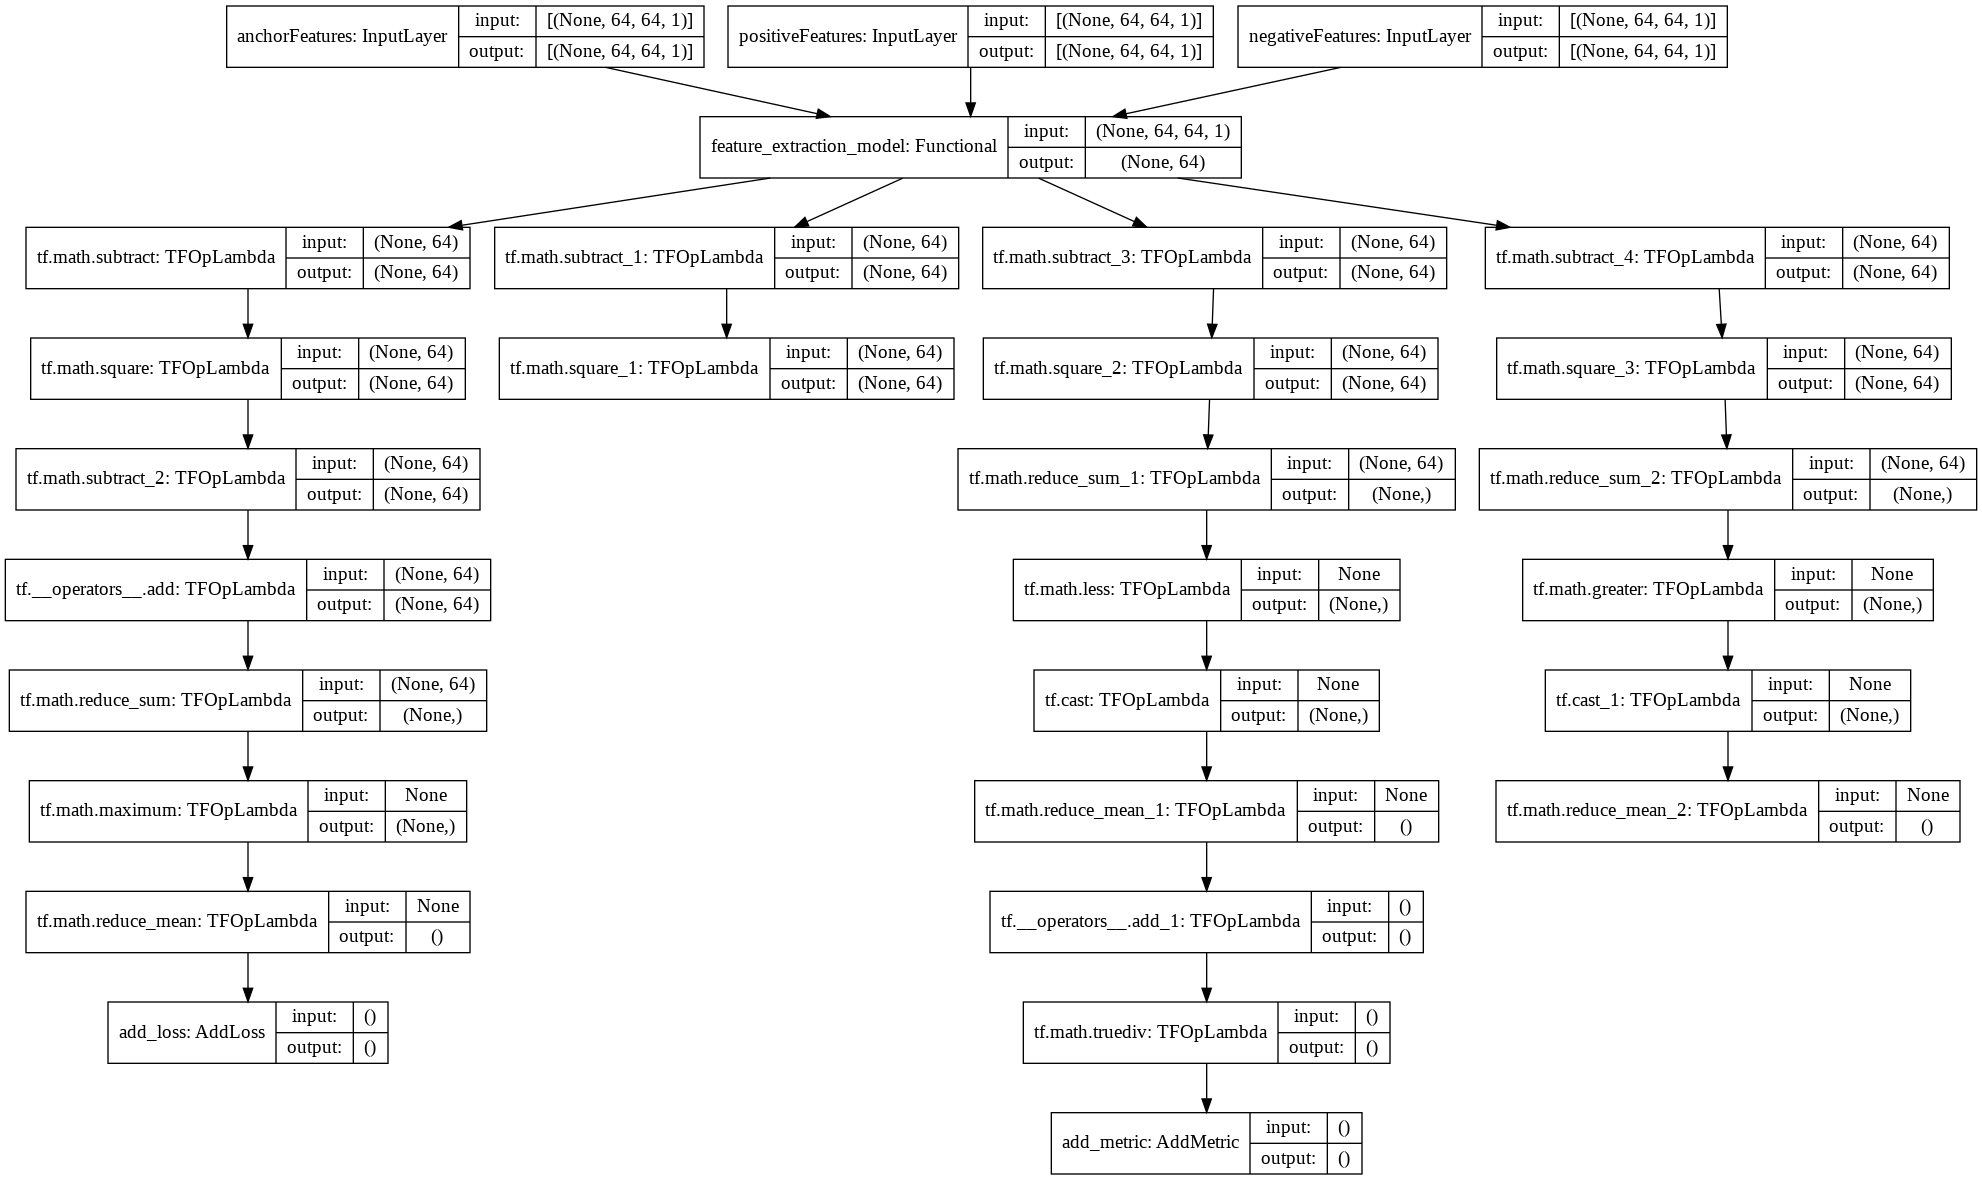

In [ ]:
keras.utils.plot_model(siameseModel, "my_first_model_with_shape_info.png", show_shapes=True)

**Triplet loss function**

In [ ]:
margin = 0.2
AP = K.square(anchorFeatures - positiveFeatures)
AN = K.square(anchorFeatures - negativeFeatures)
loss = AP - AN + margin
loss = K.sum(loss, axis = 1)
loss = K.maximum(loss, 0)
triplet_loss = K.mean(loss)

**Define accuracy metric**

In [ ]:
threshold = 10
pos_dist = K.sum(K.square(anchorFeatures - positiveFeatures), axis = 1)
neg_dist = K.sum(K.square(anchorFeatures - negativeFeatures), axis = 1)
 
correct_pos_images = K.mean(K.cast((pos_dist < threshold), 'float16')) 
correct_neg_images = K.mean(K.cast((neg_dist > threshold), 'float16')) 
accuracy = (correct_pos_images + correct_neg_images) / 2

**Training hyperparameters**

In [ ]:
siameseModel.add_loss(triplet_loss)
siameseModel.add_metric(accuracy, name = 'accuracy')
 
batch_size = 1024
epochs = 30
learning_rate = 0.0001
inputData = [anchorImagesTrain, positiveImagesTrain, negativeImagesTrain]
valData =  [anchorImagesVal, positiveImagesVal, negativeImagesVal]
callback = EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)

**Compile and train the model**

In [ ]:
siameseModel.compile(optimizer = Adam(learning_rate = learning_rate))

history = siameseModel.fit(x = inputData, y = y, batch_size = batch_size, validation_data = valData, epochs = epochs, callbacks = [callback])

Epoch 1/30
49/49 [==============================] - 45s 695ms/step - loss: 15.5485 - accuracy: 0.5327 - val_loss: 15.9189 - val_accuracy: 0.5000
Epoch 2/30
49/49 [==============================] - 27s 555ms/step - loss: 13.8224 - accuracy: 0.5942 - val_loss: 15.6775 - val_accuracy: 0.5000
Epoch 3/30
49/49 [==============================] - 27s 546ms/step - loss: 11.5829 - accuracy: 0.6709 - val_loss: 14.8310 - val_accuracy: 0.5015
Epoch 4/30
49/49 [==============================] - 27s 552ms/step - loss: 10.0942 - accuracy: 0.7104 - val_loss: 12.3502 - val_accuracy: 0.5864
Epoch 5/30
49/49 [==============================] - 27s 555ms/step - loss: 8.9814 - accuracy: 0.7339 - val_loss: 8.9280 - val_accuracy: 0.7437
Epoch 6/30
49/49 [==============================] - 27s 551ms/step - loss: 8.3083 - accuracy: 0.7515 - val_loss: 7.6967 - val_accuracy: 0.7676
Epoch 7/30
49/49 [==============================] - 27s 551ms/step - loss: 7.6804 - accuracy: 0.7642 - val_loss: 7.0255 - val_accuracy

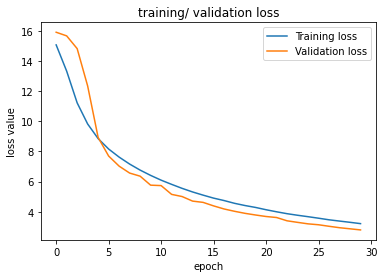

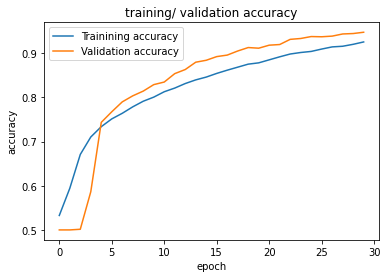

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('training/ validation loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend(loc = 'best')
plt.show()

plt.plot(history.history['accuracy'], label='Trainining accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('training/ validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc = 'best')
plt.show()

**Calculate accuracy on training set**



In [ ]:
threshold = 10
max_pos_dist = 0
min_neg_dist = 100
count = 0

for i in range(anchorImagesTest.shape[0]):  
  a = featureExtractionModel(anchorImagesTest[i:i + 1])
  p = featureExtractionModel(positiveImagesTest[i:i + 1])
  n = featureExtractionModel(negativeImagesTest[i:i + 1])

  pos_dist = np.sum(np.square(a - p), axis = 1)
  neg_dist = np.sum(np.square(a - n), axis = 1)

  if(neg_dist < threshold or pos_dist > threshold):
    count = count + 1
  
  if(pos_dist > max_pos_dist):
    max_pos_dist = pos_dist
  
  if(neg_dist < min_neg_dist):
    min_neg_dist = neg_dist
  
  if(i % 150 == 0):
    print('\b\b\b\b\b{} %'.format(int(i / 30)))   # to check the progress of the cell run

accuracy = 100 * (1 - count/anchorImagesTest.shape[0])
print('\b\b\b\b\b')
print('maximum positive distance: {}'.format(max_pos_dist))
print('minimum negative distance: {}'.format(min_neg_dist))
print('accuracy on test set: {} %'.format(accuracy))

0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %

maximum positive distance: [29.057716]
minimum negative distance: [0.6820229]
accuracy on test set: 88.7 %


**Save the model and training history**

In [ ]:
# import h5py
# import pandas as pd
# featureExtractionModel.save('/content/drive/My Drive/face-rec-feature-model-loss2.7910-lfw.h5')
# training_history = pd.DataFrame(history.history)
# training_history.to_csv('/content/drive/My Drive/trainingLogFaceRec.csv')